# Notebook 3 - Modeling binding affinity to protein receptors

By Vincent Blay, November 2021

This notebook was developed using **RPReactor 3.8** kernel on [jprime.lbl.gov](https://gpu2.ese.lbl.gov/).

In this notebook, we demonstrate the use of MACAW embeddings to model binding affinity to a protein receptor of pharmacological interest. MACAW embeddings are then applied to identify promising candidate molecules in a custom virtual library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score

#Needed to show molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 

import sys
sys.path.append('../')

import macaw
print(macaw.__version__)
from macaw import *

%run "./plotting.py"

1.0.1


In [2]:
%config InlineBackend.figure_format = 'retina'

## 1. Binding to histamine H1 receptor

### 1.1 Data preparation

In [3]:
df = pd.read_csv("./data/data_H1.csv")
Y = df.pKi
smiles = df.Smiles
df.head()

,ID,compound_id,Smiles,pKi
0,1,CHEMBL3925977,O=C(O)c1ccc2cccnc2c1N1CCN(CCc2ccc(OCCCN3CCCCCC...,5.599999
1,2,CHEMBL2171045,O=C(NS(=O)(=O)c1cccc(C(F)(F)F)c1)N1CCC(N2CCC(O...,7.400008
2,3,CHEMBL3753784,COc1ccc(CNc2nc(N3CCN(C)CC3)nc3c2CCc2ccccc2-3)c...,5.200000
3,4,CHEMBL3917794,O=C(O)c1ccc2cccc(N3CCN(CCc4ccc(OCCCN5CCCCCC5)c...,6.599998
4,5,CHEMBL240394,O=C(c1cc(F)cc(F)c1)N1CCN(c2ccc(OCCCN3CCCCC3)cc...,5.700001


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


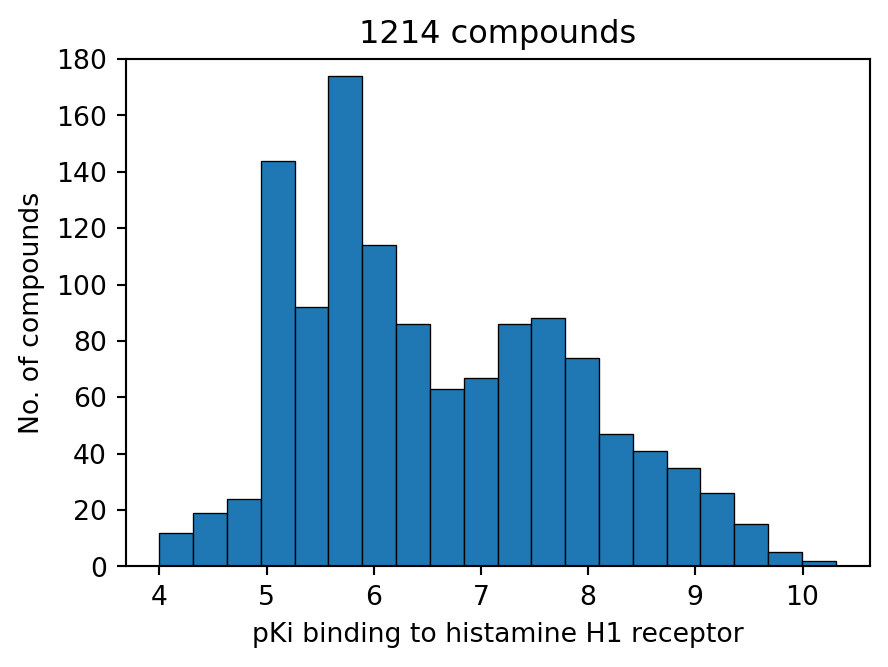

In [4]:
plot_histogram(Y, xlabel="pKi binding to histamine H1 receptor")

Define the partitions for cross-validation.

In [5]:
num_of_partitions = 10
kf = KFold(n_splits=num_of_partitions, shuffle=True, random_state=42)

Define hyperparameters for SVR:

In [6]:
param_grid = {
    'C': [1, 5, 7, 10, 30, 50, 100, 300, 500], 
    'epsilon': [0.1, 0.3, 1, 3, 5, 10, 20],
    'kernel': ['rbf']
}

Define MACAW embedding:

In [7]:
mcw = MACAW(
    type_fp='atompairs', 
    metric='sokal', 
    n_components=15, 
    n_landmarks=200, 
    random_state=39
)


In [8]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(smiles):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    smi_train , smi_val = smiles.iloc[train_index], smiles.iloc[val_index]
    y_train , y_val = Y[train_index], Y[val_index]
    
    # Compute MACAW embeddings
    mcw.fit(smi_train, y_train)
    
    X_train = mcw.transform(smi_train)
    X_val = mcw.transform(smi_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
#     print(grid.best_params_)
    
    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)

Partition 1/10
Partition 2/10
Partition 3/10
Partition 4/10
Partition 5/10
Partition 6/10
Partition 7/10
Partition 8/10
Partition 9/10
Partition 10/10
CPU times: user 1min 42s, sys: 2min 59s, total: 4min 42s
Wall time: 51.6 s


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


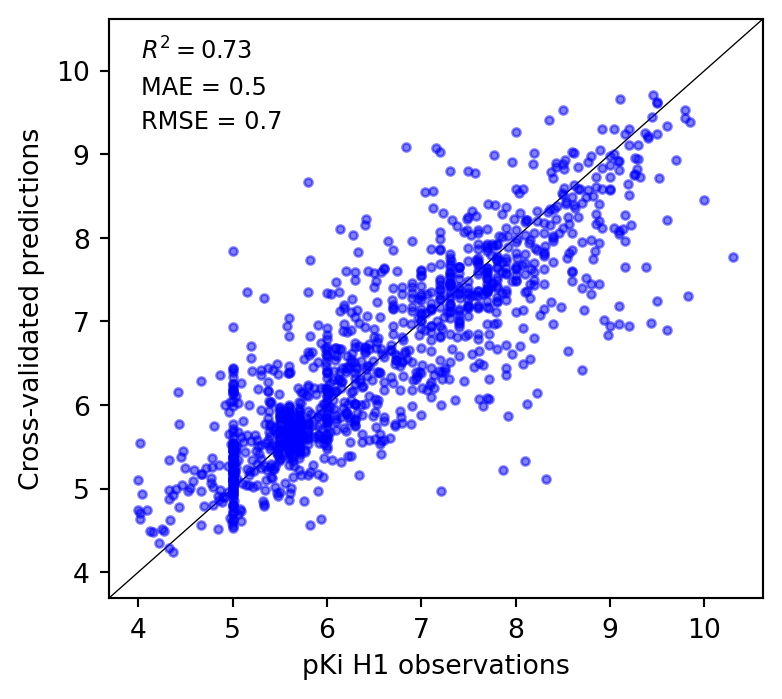

In [9]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="pKi H1 observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/macaw/H1_SVR.svg') 

Generate a model trained on the whole data set, to be used for prediction tasks

In [10]:
mcw = MACAW(
    type_fp='atompairs', 
    metric='sokal', 
    n_components=15, 
    n_landmarks=200, 
    random_state=39
)
mcw.fit(smiles, Y)

In [11]:
X_all = mcw.transform(smiles)
X_all.shape

(1214, 15)

In [12]:
# Optimize hyperparameters
regr_pred = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
regr_pred.fit(X_all, Y)
print(regr_pred.best_params_)

# Train set predictions
y_pred = regr_pred.predict(X_all)
print(f"R^2 = {r2_score(y_pred, Y):0.2f}")

{'C': 10, 'epsilon': 0.3, 'kernel': 'rbf'}
R^2 = 0.87


## 2. Binding to muscarinic receptor M2

### 2.1 Data preparation

In [13]:
df = pd.read_csv("./data/data_M2.csv")
Y = df.pKi
smiles = df.Smiles
df.head()

,ID,compound_id,Smiles,pKi
0,1,CHEMBL358493,C[N+]12CCC(CC1)C(O)(c1cc3ccccc3o1)C2,5.259637
1,2,CHEMBL343236,c1ccc2c(c1)CC(C1CN3CCC1CC3)O2,6.309894
2,3,CHEMBL150845,CC(=C1CCN(C2CCN(C(=O)c3ccc(F)c4ccccc34)CC2)CC1...,8.017729
3,4,CHEMBL593871,C[C@H]1OC[C@@H](C[N+](C)(C)C)O[C@@H]1C,4.780000
4,5,CHEMBL91404,CCOC(=O)N1CCC(N2CCC(C(=O)c3ccc(S(=O)(=O)c4ccc5...,9.886057


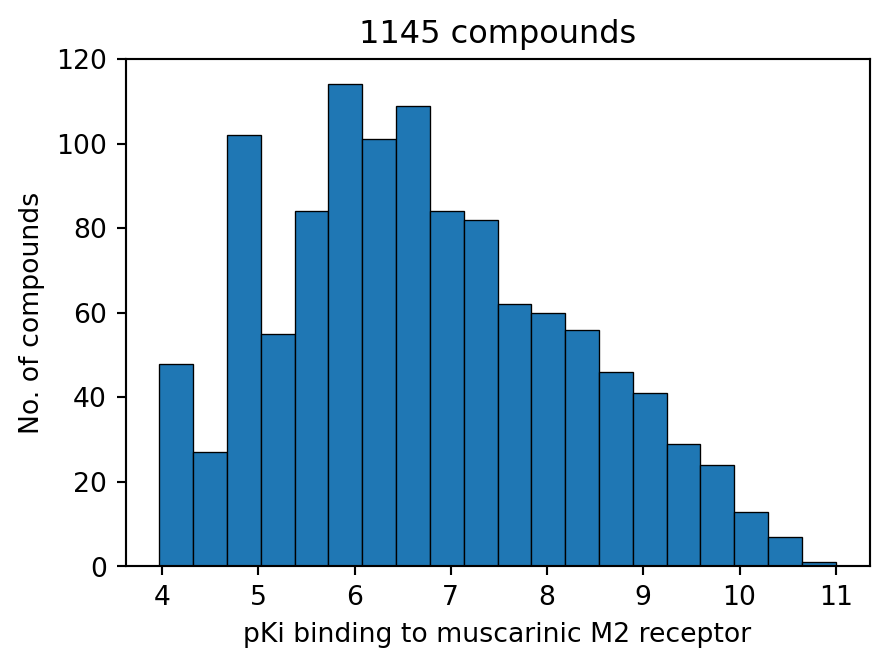

In [14]:
plot_histogram(Y, xlabel="pKi binding to muscarinic M2 receptor")

In [15]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(smiles):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    smi_train , smi_val = smiles.iloc[train_index], smiles.iloc[val_index]
    y_train , y_val = Y[train_index], Y[val_index]
    
    # Compute MACAW embeddings
    mcw2 = MACAW_optimus(
        smi_train, 
        y=y_train, 
        C=5, 
        verbose=False, 
        n_landmarks=200, 
        exhaustiveness=1, 
        random_state=41
    )
    
    X_train = mcw2.transform(smi_train)
    X_val = mcw2.transform(smi_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid2 = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid2.fit(X_train, y_train)

    # Test set predictions
    y_cv_pred = grid2.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)

Partition 1/10
Problem type identified as regression
Setting recommended combination: morgan2 & dice
Partition 2/10
Problem type identified as regression
Setting recommended combination: rdk5 & tanimoto
Partition 3/10
Problem type identified as regression
Setting recommended combination: atompairs & manhattan
Partition 4/10
Problem type identified as regression
Setting recommended combination: layered & rogot-goldberg
Partition 5/10
Problem type identified as regression
Setting recommended combination: avalon & dice
Partition 6/10
Problem type identified as regression
Setting recommended combination: atompairs & manhattan
Partition 7/10
Problem type identified as regression
Setting recommended combination: atompairs & rogot-goldberg
Partition 8/10
Problem type identified as regression
Setting recommended combination: morgan2 & kulczynski
Partition 9/10
Problem type identified as regression
Setting recommended combination: atompairs & rogot-goldberg
Partition 10/10
Problem type identifi

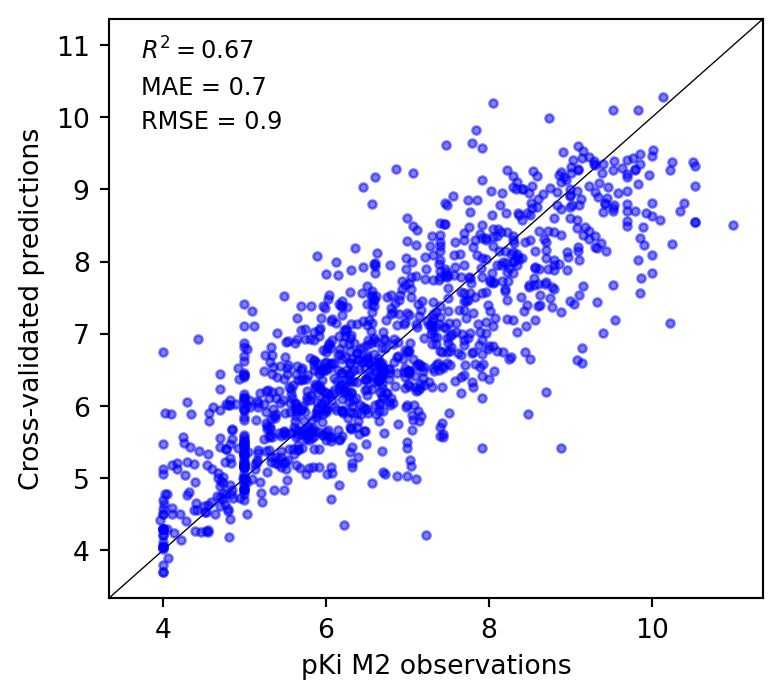

In [16]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="pKi M2 observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/macaw/M2_SVR.svg') 

Generate a model trained on the whole data set, to be used for prediction tasks

In [17]:
mcw2 = MACAW_optimus(
    smiles, 
    y=Y, 
    C=5, 
    verbose=True, 
    n_landmarks=200, 
    exhaustiveness=1, 
    random_state=41
)

Problem type identified as regression
morgan2 & tanimoto: 0.626
morgan3 & tanimoto: 0.645
rdk5 & tanimoto: 0.535
rdk7 & tanimoto: 0.528
featmorgan2 & tanimoto: 0.475
featmorgan3 & tanimoto: 0.489
maccs & tanimoto: 0.478
avalon & tanimoto: 0.513
atompairs & tanimoto: 0.587
torsion & tanimoto: 0.591
pattern & tanimoto: 0.507
secfp6 & tanimoto: 0.535
layered & tanimoto: 0.554
morgan3 & tanimoto: 0.645
morgan3 & cosine: 0.614
morgan3 & dice: 0.618
morgan3 & sokal: 0.590
morgan3 & kulczynski: 0.617
morgan3 & mcconnaughey: 0.617
morgan3 & braun-blanquet: 0.628
morgan3 & rogot-goldberg: 0.618
morgan3 & asymmetric: 0.624
morgan3 & manhattan: 0.564
morgan3 & blay-roger: 0.592
Setting recommended combination: morgan3 & tanimoto


In [18]:
X_all = mcw2.transform(smiles)
X_all.shape

(1145, 15)

In [19]:
# Optimize hyperparameters
regr2_pred = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
regr2_pred.fit(X_all, Y)
print(regr2_pred.best_params_)

# Train set predictions
y_pred = regr2_pred.predict(X_all)
print(f"R^2 = {r2_score(y_pred, Y):0.2f}")

{'C': 7, 'epsilon': 0.3, 'kernel': 'rbf'}
R^2 = 0.73


## 3. Discovery of new hits specific to H1

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` and `regr2` above, which use 15-D MACAW embeddings as their input. The custom library ("LibraryVB.csv") is a custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted binding affinity to the H1 receptor and comparatively low predicted binding affinity to the M2 receptor.

In [20]:
mylib = pd.read_csv("./data/LibraryVB.csv")
print(mylib.shape)
mylib.head()

(19490, 2)


,Smiles,Source
0,NC(=O)NC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
1,CC(C)CNC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
2,O=C(Cn1cccnc1=O)NC1CCCCCC1,Enamine_antivirals
3,CCC(=O)Nc1ccc(cn1)N1CCOCC1,Enamine_antivirals
4,Cc1nn(C)c(C)c1CC(=O)NC(C1CC1)C1CC1,Enamine_antivirals


In [21]:
smi_lib = mylib.Smiles

Generate predictions for the H1 receptor:

In [22]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

Generate predictions for the M2 receptor:

In [23]:
X2_lib = mcw2.transform(smi_lib)

Y2_lib_pred = regr2_pred.predict(X2_lib)

Let us represent the predictions of both models:

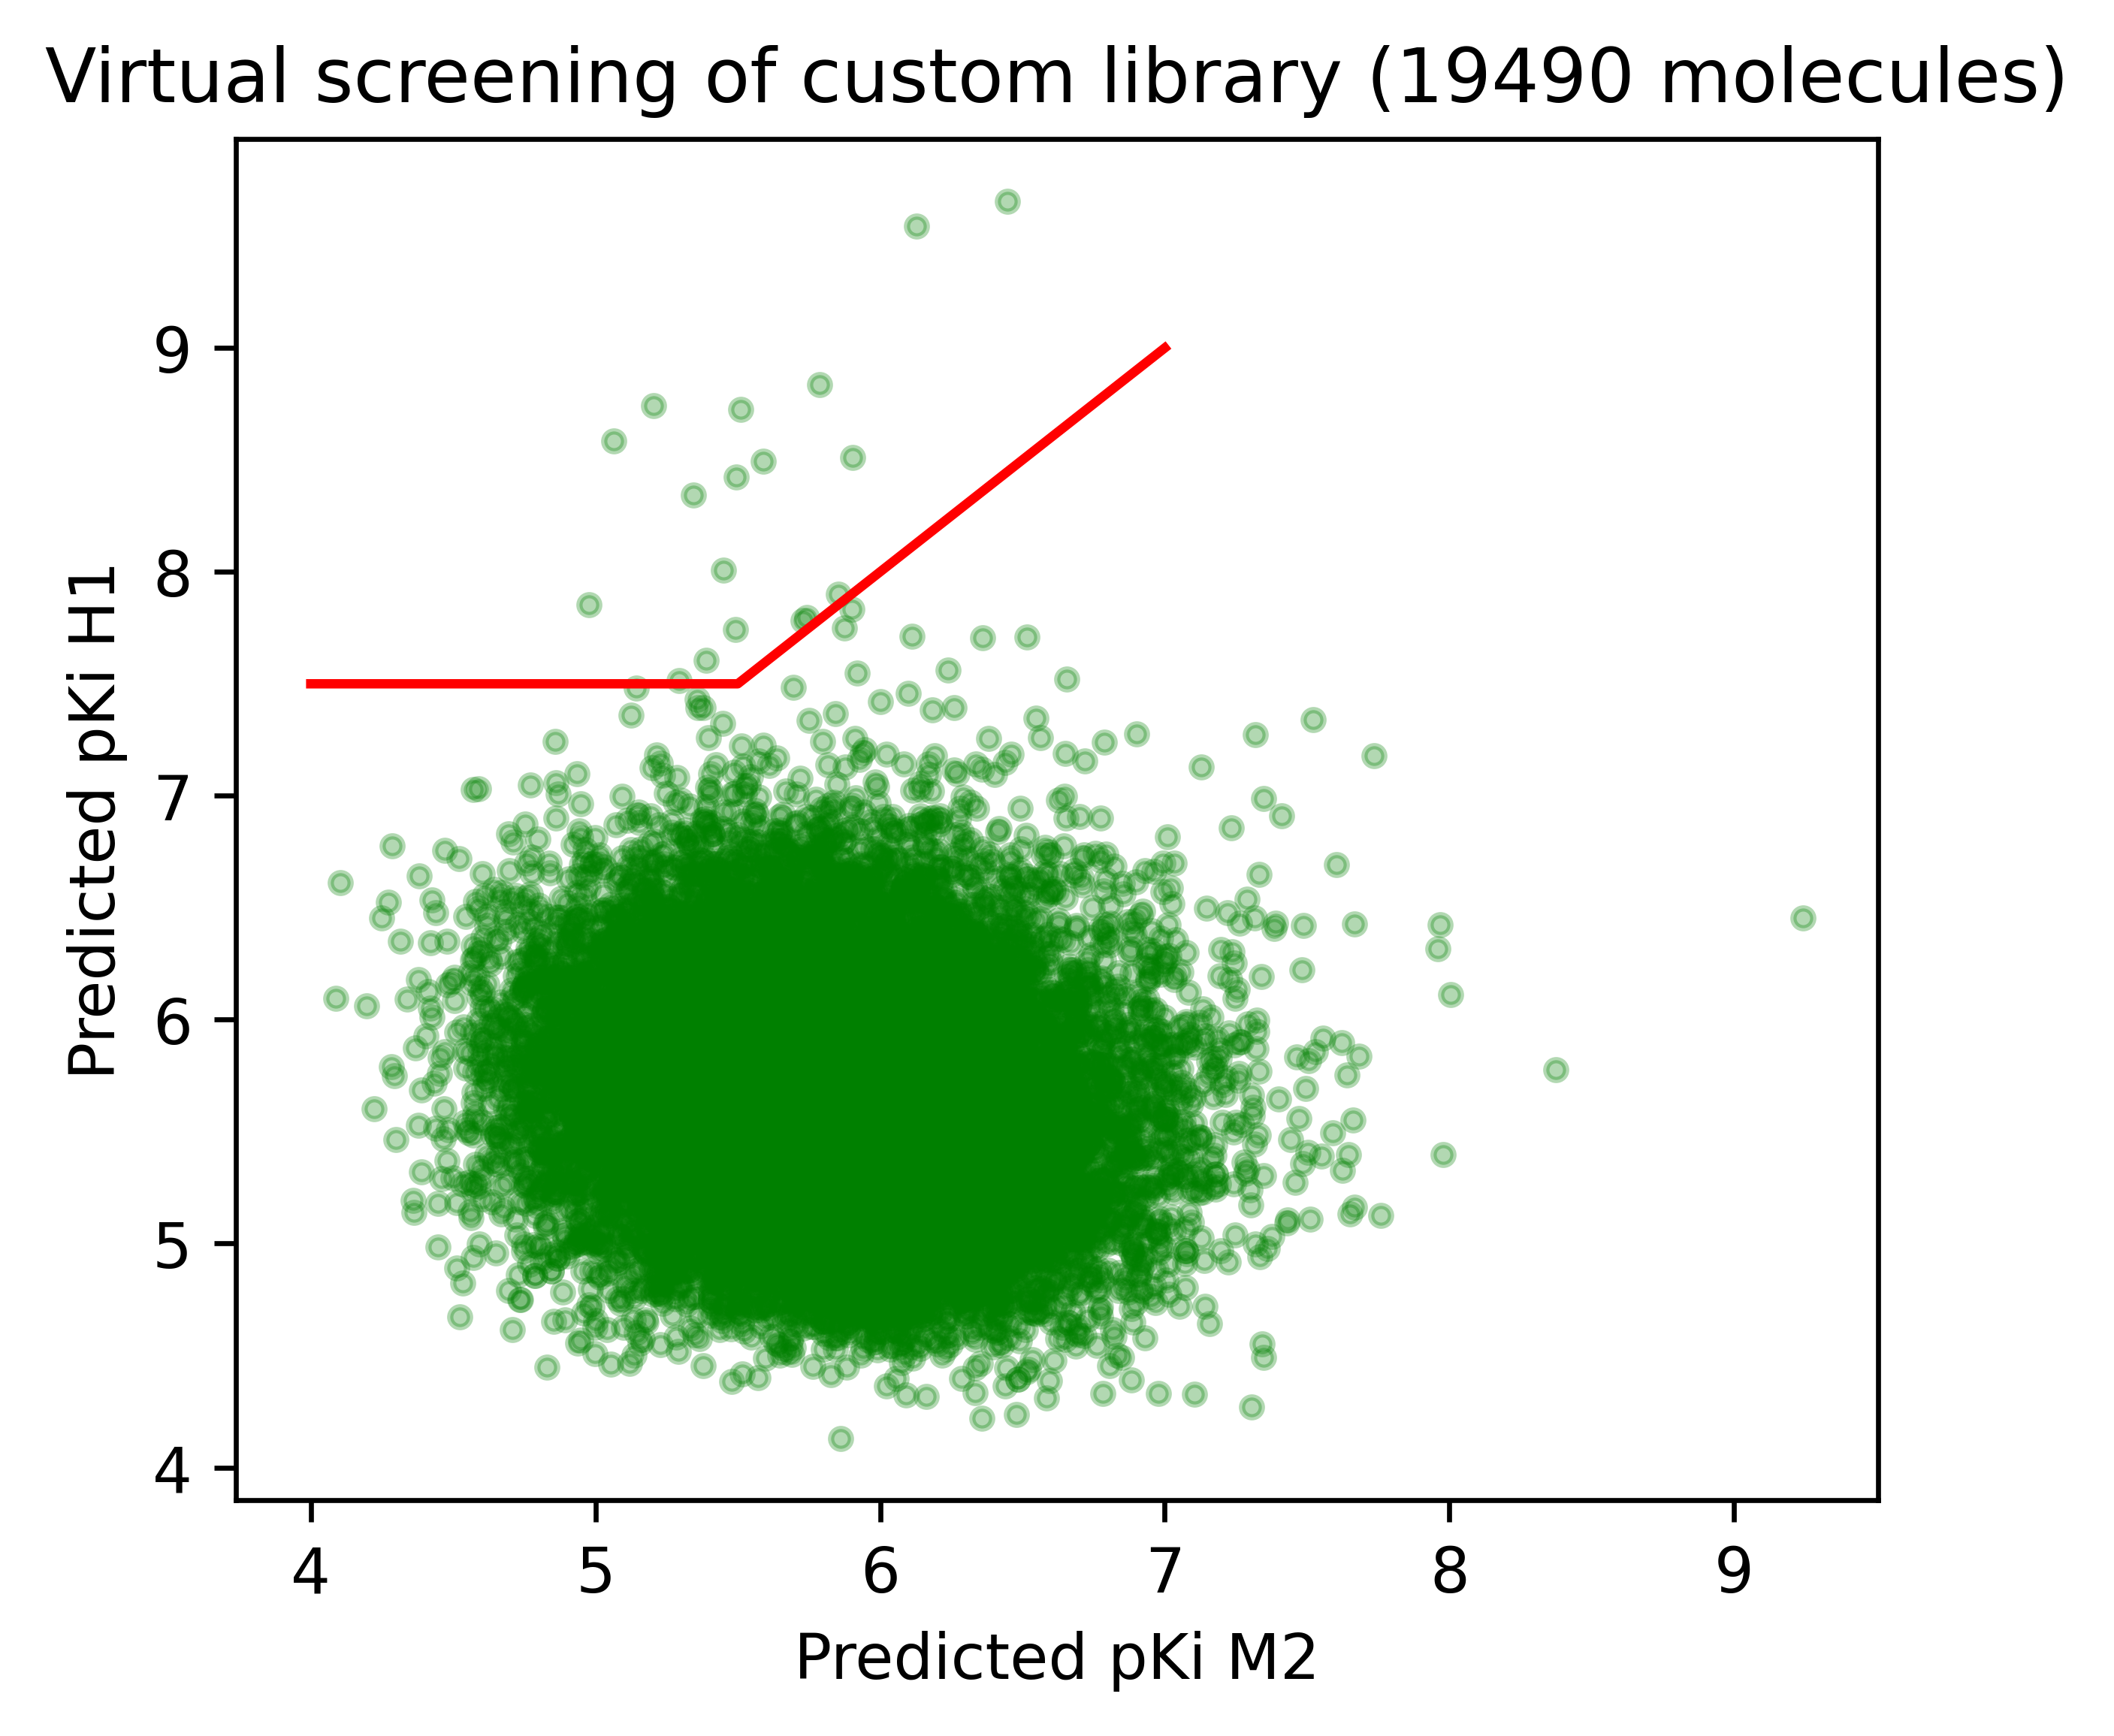

In [24]:
plt.figure(figsize=(4.7,4.0), dpi=300)
plt.scatter(x=Y2_lib_pred, y=Y1_lib_pred, s=10, c='green', alpha=0.3) 
plt.xlabel("Predicted pKi M2")
plt.ylabel("Predicted pKi H1")
plt.title(f"Virtual screening of custom library ({len(smi_lib)} molecules)")
plt.plot([4,5.5,7],[7.5,7.5,9],c='red')
plt.savefig("./results/macaw/H1_library_screening.svg", bbox_inches='tight', dpi=300)

Let us have a look at the compounds:

In [25]:
idx = np.where((Y1_lib_pred > 7.5)*(Y1_lib_pred > (Y2_lib_pred + 2.)))[0]

In [26]:
lead_df = mylib.iloc[idx].copy()
lead_df['pKi_H1_pred'] = Y1_lib_pred[idx]
lead_df['pKi_M2_pred'] = Y2_lib_pred[idx]

lead_df

,Smiles,Source,pKi_H1_pred,pKi_M2_pred
13946,CN(C)CC/C=C\1/c2ccccc2COc2ccccc12,Enamine_Phenotypic,9.543668,6.126914
14440,OCCN1C(=O)c2cccc3c(ccc(C1=O)c23)N1CCCCC1,Enamine_Phenotypic,7.796783,5.743504
14508,CN(C)CCOC(c1ccc(Cl)cc1)c1ccccn1,Enamine_Phenotypic,8.343310,5.344076
14673,CN(C)CCN(Cc1ccccc1)c1ccccn1,Enamine_Phenotypic,8.585471,5.065380
14978,CN(C)CC[C@@H](c1ccc(Cl)cc1)c1ccccn1,Enamine_Phenotypic,8.837102,5.786209
15364,CN1CCN2C(C1)c1ccccc1Cc1cccnc21,Enamine_Phenotypic,8.495600,5.588621
15938,CN1CCC(=CC1)c1c[nH]c2ccccc12,Enamine_Phenotypic,8.007862,5.449677
17743,C(c1ccccc1)n1c(nc2ccccc12)N1CCNCC1,Enamine_Phenotypic,8.743561,5.205525
18198,CN1CCC[C@@H]1CCO[C@](C)(c1ccccc1)c1ccc(Cl)cc1,Enamine_Phenotypic,9.655742,6.446592
18212,CC(C(=O)O)c1ccc2c(c1)[nH]c1ccc(Cl)cc21,Enamine_Phenotypic,7.515393,5.294934


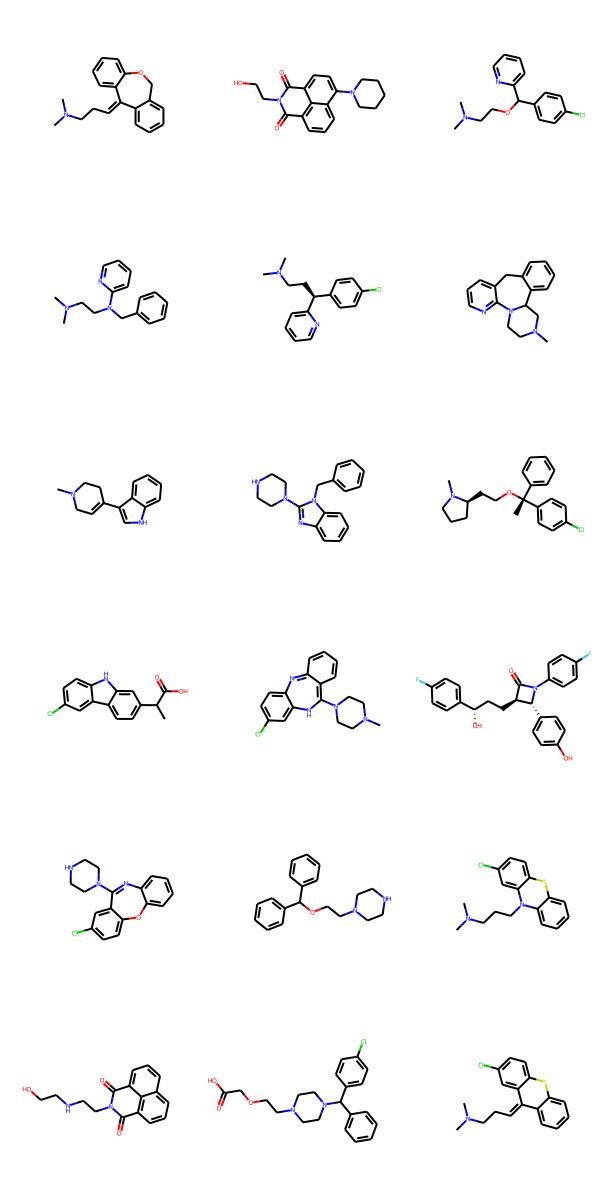

In [27]:
molecules = [Chem.MolFromSmiles(smi) for smi in lead_df.Smiles[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)